<a href="https://colab.research.google.com/github/mawadiod/Sims_GAN/blob/main/sims_stylegan_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sims GAN


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Getting Started

You will begin by importing some packages from PyTorch and defining a visualization function which will be useful later.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchvision.utils import make_grid

def show_tensor_images(image_tensor, num_images=16, size=(3, 128,128), fname=""):
    '''
    Function for visualizing images: Given a tensor of images, number of images,
    size per image, and images per row, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu().clamp_(0, 1)
    image_grid = make_grid(image_unflat[:num_images], nrow=4, padding=0)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    if fname != "":
      plt.savefig(fname)
    plt.show()
    return plt

Now let's take a look at the code to preprocess and prepare the data.

In [ ]:
import os

import torchvision.transforms as transforms
from PIL import Image
import numpy as np

class Dataset(torch.utils.data.Dataset):

    def __init__(self, root, n_classes=10, resolution=128):
        super().__init__()

        self.n_classes = n_classes

        # List of paths to training examples
        self.examples = []
        self.load_examples_from_dir(root)

        # Initialize transforms
        self.transforms = transforms.Compose([
            transforms.Resize((resolution, resolution), Image.LANCZOS),
            transforms.RandomHorizontalFlip(),
            transforms.Lambda(lambda x: np.array(x)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

    def load_examples_from_dir(self, abs_path):
        '''
        Given a folder of examples, this function returns a list of paired examples.
        '''
        assert os.path.isdir(abs_path)

        img_suffix = '.jpg'

        n_classes = 0
        for root, _, files in os.walk(abs_path):
            if n_classes == self.n_classes:
                break
            for f in files:
                if f.endswith(img_suffix):
                    self.examples.append(root + '/' + f)
            n_classes += 1

    def __getitem__(self, idx):
        example = self.examples[idx]
        img = Image.open(example).convert('RGB')
        return self.transforms(img)

    def __len__(self):
        return len(self.examples)

## Prepare Google drive directories

In [ ]:
# import os
# os.makedirs("/content/drive/MyDrive/data/gan")
# os.makedirs("/content/drive/MyDrive/data/gan/dataset/")
# os.makedirs("/content/drive/MyDrive/data/gan/experiments/")
# os.makedirs("/content/drive/MyDrive/data/gan/images/")

In [ ]:
# !unzip /content/drive/MyDrive/data/gan/images/sims_imgz.zip -d /content/drive/MyDrive/data/gan/images/

## StyleGAN

You should already be familiar with StyleGAN and its implementation. As in the FreezeD paper, the source code below is taken from [this](https://github.com/rosinality/style-based-gan-pytorch) repository, which also provides a pretrained checkpoint.

In [ ]:
#@title Code (double click to view) { form-width: "200px", display-mode: "code" }

''' Taken from https://github.com/rosinality/style-based-gan-pytorch/blob/master/model.py '''
# MIT License
#
# Copyright (c) 2019 Kim Seonghyeon
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

from torch.nn import init
from torch.autograd import Function

from math import sqrt

import random


def init_linear(linear):
    init.xavier_normal(linear.weight)
    linear.bias.data.zero_()


def init_conv(conv, glu=True):
    init.kaiming_normal(conv.weight)
    if conv.bias is not None:
        conv.bias.data.zero_()


class EqualLR:
    def __init__(self, name):
        self.name = name

    def compute_weight(self, module):
        weight = getattr(module, self.name + '_orig')
        fan_in = weight.data.size(1) * weight.data[0][0].numel()

        return weight * sqrt(2 / fan_in)

    @staticmethod
    def apply(module, name):
        fn = EqualLR(name)

        weight = getattr(module, name)
        del module._parameters[name]
        module.register_parameter(name + '_orig', nn.Parameter(weight.data))
        module.register_forward_pre_hook(fn)

        return fn

    def __call__(self, module, input):
        weight = self.compute_weight(module)
        setattr(module, self.name, weight)


def equal_lr(module, name='weight'):
    EqualLR.apply(module, name)

    return module


class FusedUpsample(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, padding=0):
        super().__init__()

        weight = torch.randn(in_channel, out_channel, kernel_size, kernel_size)
        bias = torch.zeros(out_channel)

        fan_in = in_channel * kernel_size * kernel_size
        self.multiplier = sqrt(2 / fan_in)

        self.weight = nn.Parameter(weight)
        self.bias = nn.Parameter(bias)

        self.pad = padding

    def forward(self, input):
        weight = F.pad(self.weight * self.multiplier, [1, 1, 1, 1])
        weight = (
            weight[:, :, 1:, 1:]
            + weight[:, :, :-1, 1:]
            + weight[:, :, 1:, :-1]
            + weight[:, :, :-1, :-1]
        ) / 4

        out = F.conv_transpose2d(input, weight, self.bias, stride=2, padding=self.pad)

        return out


class FusedDownsample(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, padding=0):
        super().__init__()

        weight = torch.randn(out_channel, in_channel, kernel_size, kernel_size)
        bias = torch.zeros(out_channel)

        fan_in = in_channel * kernel_size * kernel_size
        self.multiplier = sqrt(2 / fan_in)

        self.weight = nn.Parameter(weight)
        self.bias = nn.Parameter(bias)

        self.pad = padding

    def forward(self, input):
        weight = F.pad(self.weight * self.multiplier, [1, 1, 1, 1])
        weight = (
            weight[:, :, 1:, 1:]
            + weight[:, :, :-1, 1:]
            + weight[:, :, 1:, :-1]
            + weight[:, :, :-1, :-1]
        ) / 4

        out = F.conv2d(input, weight, self.bias, stride=2, padding=self.pad)

        return out


class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input / torch.sqrt(torch.mean(input ** 2, dim=1, keepdim=True) + 1e-8)


class BlurFunctionBackward(Function):
    @staticmethod
    def forward(ctx, grad_output, kernel, kernel_flip):
        ctx.save_for_backward(kernel, kernel_flip)

        grad_input = F.conv2d(
            grad_output, kernel_flip, padding=1, groups=grad_output.shape[1]
        )

        return grad_input

    @staticmethod
    def backward(ctx, gradgrad_output):
        kernel, kernel_flip = ctx.saved_tensors

        grad_input = F.conv2d(
            gradgrad_output, kernel, padding=1, groups=gradgrad_output.shape[1]
        )

        return grad_input, None, None


class BlurFunction(Function):
    @staticmethod
    def forward(ctx, input, kernel, kernel_flip):
        ctx.save_for_backward(kernel, kernel_flip)

        output = F.conv2d(input, kernel, padding=1, groups=input.shape[1])

        return output

    @staticmethod
    def backward(ctx, grad_output):
        kernel, kernel_flip = ctx.saved_tensors

        grad_input = BlurFunctionBackward.apply(grad_output, kernel, kernel_flip)

        return grad_input, None, None


blur = BlurFunction.apply


class Blur(nn.Module):
    def __init__(self, channel):
        super().__init__()

        weight = torch.tensor([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=torch.float32)
        weight = weight.view(1, 1, 3, 3)
        weight = weight / weight.sum()
        weight_flip = torch.flip(weight, [2, 3])

        self.register_buffer('weight', weight.repeat(channel, 1, 1, 1))
        self.register_buffer('weight_flip', weight_flip.repeat(channel, 1, 1, 1))

    def forward(self, input):
        return blur(input, self.weight, self.weight_flip)
        # return F.conv2d(input, self.weight, padding=1, groups=input.shape[1])


class EqualConv2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

        conv = nn.Conv2d(*args, **kwargs)
        conv.weight.data.normal_()
        conv.bias.data.zero_()
        self.conv = equal_lr(conv)

    def forward(self, input):
        return self.conv(input)


class EqualLinear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()

        linear = nn.Linear(in_dim, out_dim)
        linear.weight.data.normal_()
        linear.bias.data.zero_()

        self.linear = equal_lr(linear)

    def forward(self, input):
        return self.linear(input)


class ConvBlock(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        padding,
        kernel_size2=None,
        padding2=None,
        downsample=False,
        fused=False,
    ):
        super().__init__()

        pad1 = padding
        pad2 = padding
        if padding2 is not None:
            pad2 = padding2

        kernel1 = kernel_size
        kernel2 = kernel_size
        if kernel_size2 is not None:
            kernel2 = kernel_size2

        self.conv1 = nn.Sequential(
            EqualConv2d(in_channel, out_channel, kernel1, padding=pad1),
            nn.LeakyReLU(0.2),
        )

        if downsample:
            if fused:
                self.conv2 = nn.Sequential(
                    Blur(out_channel),
                    FusedDownsample(out_channel, out_channel, kernel2, padding=pad2),
                    nn.LeakyReLU(0.2),
                )

            else:
                self.conv2 = nn.Sequential(
                    Blur(out_channel),
                    EqualConv2d(out_channel, out_channel, kernel2, padding=pad2),
                    nn.AvgPool2d(2),
                    nn.LeakyReLU(0.2),
                )

        else:
            self.conv2 = nn.Sequential(
                EqualConv2d(out_channel, out_channel, kernel2, padding=pad2),
                nn.LeakyReLU(0.2),
            )

    def forward(self, input):
        out = self.conv1(input)
        out = self.conv2(out)

        return out


class AdaptiveInstanceNorm(nn.Module):
    def __init__(self, in_channel, style_dim):
        super().__init__()

        self.norm = nn.InstanceNorm2d(in_channel)
        self.style = EqualLinear(style_dim, in_channel * 2)

        self.style.linear.bias.data[:in_channel] = 1
        self.style.linear.bias.data[in_channel:] = 0

    def forward(self, input, style):
        style = self.style(style).unsqueeze(2).unsqueeze(3)
        gamma, beta = style.chunk(2, 1)

        out = self.norm(input)
        out = gamma * out + beta

        return out


class NoiseInjection(nn.Module):
    def __init__(self, channel):
        super().__init__()

        self.weight = nn.Parameter(torch.zeros(1, channel, 1, 1))

    def forward(self, image, noise):
        return image + self.weight * noise


class ConstantInput(nn.Module):
    def __init__(self, channel, size=4):
        super().__init__()

        self.input = nn.Parameter(torch.randn(1, channel, size, size))

    def forward(self, input):
        batch = input.shape[0]
        out = self.input.repeat(batch, 1, 1, 1)

        return out


class StyledConvBlock(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size=3,
        padding=1,
        style_dim=512,
        initial=False,
        upsample=False,
        fused=False,
    ):
        super().__init__()

        if initial:
            self.conv1 = ConstantInput(in_channel)

        else:
            if upsample:
                if fused:
                    self.conv1 = nn.Sequential(
                        FusedUpsample(
                            in_channel, out_channel, kernel_size, padding=padding
                        ),
                        Blur(out_channel),
                    )

                else:
                    self.conv1 = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='nearest'),
                        EqualConv2d(
                            in_channel, out_channel, kernel_size, padding=padding
                        ),
                        Blur(out_channel),
                    )

            else:
                self.conv1 = EqualConv2d(
                    in_channel, out_channel, kernel_size, padding=padding
                )

        self.noise1 = equal_lr(NoiseInjection(out_channel))
        self.adain1 = AdaptiveInstanceNorm(out_channel, style_dim)
        self.lrelu1 = nn.LeakyReLU(0.2)

        self.conv2 = EqualConv2d(out_channel, out_channel, kernel_size, padding=padding)
        self.noise2 = equal_lr(NoiseInjection(out_channel))
        self.adain2 = AdaptiveInstanceNorm(out_channel, style_dim)
        self.lrelu2 = nn.LeakyReLU(0.2)

    def forward(self, input, style, noise):
        out = self.conv1(input)
        out = self.noise1(out, noise)
        out = self.lrelu1(out)
        out = self.adain1(out, style)

        out = self.conv2(out)
        out = self.noise2(out, noise)
        out = self.lrelu2(out)
        out = self.adain2(out, style)

        return out


class Generator(nn.Module):
    def __init__(self, code_dim, fused=True):
        super().__init__()

        self.progression = nn.ModuleList(
            [
                StyledConvBlock(512, 512, 3, 1, initial=True),  # 4
                StyledConvBlock(512, 512, 3, 1, upsample=True),  # 8
                StyledConvBlock(512, 512, 3, 1, upsample=True),  # 16
                StyledConvBlock(512, 512, 3, 1, upsample=True),  # 32
                StyledConvBlock(512, 256, 3, 1, upsample=True),  # 64
                StyledConvBlock(256, 128, 3, 1, upsample=True, fused=fused),  # 128
                StyledConvBlock(128, 64, 3, 1, upsample=True, fused=fused),  # 256
                StyledConvBlock(64, 32, 3, 1, upsample=True, fused=fused),  # 512
                StyledConvBlock(32, 16, 3, 1, upsample=True, fused=fused),  # 1024
            ]
        )

        self.to_rgb = nn.ModuleList(
            [
                EqualConv2d(512, 3, 1),
                EqualConv2d(512, 3, 1),
                EqualConv2d(512, 3, 1),
                EqualConv2d(512, 3, 1),
                EqualConv2d(256, 3, 1),
                EqualConv2d(128, 3, 1),
                EqualConv2d(64, 3, 1),
                EqualConv2d(32, 3, 1),
                EqualConv2d(16, 3, 1),
            ]
        )

        # self.blur = Blur()

    def forward(self, style, noise, step=0, alpha=-1, mixing_range=(-1, -1)):
        out = noise[0]

        if len(style) < 2:
            inject_index = [len(self.progression) + 1]

        else:
            inject_index = sorted(random.sample(list(range(step)), len(style) - 1))

        crossover = 0

        for i, (conv, to_rgb) in enumerate(zip(self.progression, self.to_rgb)):
            if mixing_range == (-1, -1):
                if crossover < len(inject_index) and i > inject_index[crossover]:
                    crossover = min(crossover + 1, len(style))

                style_step = style[crossover]

            else:
                if mixing_range[0] <= i <= mixing_range[1]:
                    style_step = style[1]

                else:
                    style_step = style[0]

            if i > 0 and step > 0:
                out_prev = out
                
            out = conv(out, style_step, noise[i])

            if i == step:
                out = to_rgb(out)

                if i > 0 and 0 <= alpha < 1:
                    skip_rgb = self.to_rgb[i - 1](out_prev)
                    skip_rgb = F.interpolate(skip_rgb, scale_factor=2, mode='nearest')
                    out = (1 - alpha) * skip_rgb + alpha * out

                break

        return out


class StyledGenerator(nn.Module):
    def __init__(self, code_dim=512, n_mlp=8):
        super().__init__()

        self.generator = Generator(code_dim)

        layers = [PixelNorm()]
        for i in range(n_mlp):
            layers.append(EqualLinear(code_dim, code_dim))
            layers.append(nn.LeakyReLU(0.2))

        self.style = nn.Sequential(*layers)

    def forward(
        self,
        input,
        noise=None,
        step=0,
        alpha=-1,
        mean_style=None,
        style_weight=0,
        mixing_range=(-1, -1),
    ):
        styles = []
        if type(input) not in (list, tuple):
            input = [input]

        for i in input:
            styles.append(self.style(i))

        batch = input[0].shape[0]

        if noise is None:
            noise = []

            for i in range(step + 1):
                size = 4 * 2 ** i
                noise.append(torch.randn(batch, 1, size, size, device=input[0].device))

        if mean_style is not None:
            styles_norm = []

            for style in styles:
                styles_norm.append(mean_style + style_weight * (style - mean_style))

            styles = styles_norm

        return self.generator(styles, noise, step, alpha, mixing_range=mixing_range)

    def mean_style(self, input):
        style = self.style(input).mean(0, keepdim=True)

        return style


class Discriminator(nn.Module):
    def __init__(self, fused=True, from_rgb_activate=False):
        super().__init__()

        self.progression = nn.ModuleList(
            [
                ConvBlock(16, 32, 3, 1, downsample=True, fused=fused),  # 512
                ConvBlock(32, 64, 3, 1, downsample=True, fused=fused),  # 256
                ConvBlock(64, 128, 3, 1, downsample=True, fused=fused),  # 128
                ConvBlock(128, 256, 3, 1, downsample=True, fused=fused),  # 64
                ConvBlock(256, 512, 3, 1, downsample=True),  # 32
                ConvBlock(512, 512, 3, 1, downsample=True),  # 16
                ConvBlock(512, 512, 3, 1, downsample=True),  # 8
                ConvBlock(512, 512, 3, 1, downsample=True),  # 4
                ConvBlock(513, 512, 3, 1, 4, 0),
            ]
        )

        def make_from_rgb(out_channel):
            if from_rgb_activate:
                return nn.Sequential(EqualConv2d(3, out_channel, 1), nn.LeakyReLU(0.2))

            else:
                return EqualConv2d(3, out_channel, 1)

        self.from_rgb = nn.ModuleList(
            [
                make_from_rgb(16),
                make_from_rgb(32),
                make_from_rgb(64),
                make_from_rgb(128),
                make_from_rgb(256),
                make_from_rgb(512),
                make_from_rgb(512),
                make_from_rgb(512),
                make_from_rgb(512),
            ]
        )

        # self.blur = Blur()

        self.n_layer = len(self.progression)

        self.linear = EqualLinear(512, 1)

    def forward(self, input, step=0, alpha=-1):
        for i in range(step, -1, -1):
            index = self.n_layer - i - 1

            if i == step:
                out = self.from_rgb[index](input)

            if i == 0:
                out_std = torch.sqrt(out.var(0, unbiased=False) + 1e-8)
                mean_std = out_std.mean()
                mean_std = mean_std.expand(out.size(0), 1, 4, 4)
                out = torch.cat([out, mean_std], 1)

            out = self.progression[index](out)

            if i > 0:
                if i == step and 0 <= alpha < 1:
                    skip_rgb = F.avg_pool2d(input, 2)
                    skip_rgb = self.from_rgb[index + 1](skip_rgb)

                    out = (1 - alpha) * skip_rgb + alpha * out

        out = out.squeeze(2).squeeze(2)
        # print(input.size(), out.size(), step)
        out = self.linear(out)

        return out

### Checkpoint

Run the cell below to download the StyleGAN checkpoint.

In [ ]:
# # Download public StyleGAN 256x256 resolution model to `stylegan-256px.pt`
# import os
# if 'stylegan-256px.pt' not in os.listdir(os.getcwd()):
#     !wget --load-cookies /tmp/cookies.txt "https://drive.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1QlXFPIOFzsJyjZ1AtfpnVhqW4Z0r8GLZ' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1QlXFPIOFzsJyjZ1AtfpnVhqW4Z0r8GLZ" -O stylegan-256px.pt && rm -rf /tmp/cookies.txt

### Add stylegan checkpoint to drive

In [ ]:
# !mkdir -p /content/drive/MyDrive/data/gan/checkpoints
# !cp stylegan-256px.pt /content/drive/MyDrive/data/gan/checkpoints/

In [ ]:
checkpoints_dir = '/content/drive/MyDrive/data/gan/checkpoints/sims/pickles/'
images_dir      = '/content/drive/MyDrive/data/gan/checkpoints/sims/images/'
# !mkdir $checkpoints_dir

## Some Useful Functions

Before jumping into the fine-tuning code, let's first implement some useful functions

### Exponential Moving Average (EMA) of Model Weights

In fine-tuning, the authors keep an exponential moving average of the weights for the generator for inference.

This is relatively common in deep learning since it helps stabilize the converged model (similar to how optimizers like Adam and layers like batch normalization keep exponential moving averages to stabilize their statistics across multiple updates).

In [ ]:
def init_ema(model):
    '''
    Function that initializes a static model to store exponential moving average.
    '''
    model.eval()
    for p in model.parameters():
        p.requires_grad = False

def accumulate_ema_weights(model_ema, model_tgt, decay=0.999):
    '''
    Function for updating exponential moving average of weights.
    '''
    ema = dict(model_ema.named_parameters())
    tgt = dict(model_tgt.named_parameters())

    for p_ema, p_tgt in zip(ema.values(), tgt.values()):
        p_ema.data.mul_(decay).add_(p_tgt.data, alpha=1-decay)

### Mixing Regularization

You've already learned about mixing regularization in the StyleGAN notebook, so this section will just implement the function to be used in fine-tuning.

In [ ]:
def sample_noise(batch_size, code_dim, device, p=0.9):
    '''
    Function that samples noise with mixing regularization with probability p.
    '''
    if random.random() < p:
        z11, z12, z21, z22 = torch.randn(4, batch_size, code_dim, device=device).unbind(0)
        z1 = [z11, z12]
        z2 = [z21, z22]

    else:
        z1, z2 = torch.randn(2, batch_size, code_dim, device=device).unbind(0)

    return z1, z2

### Gradient Penalty

This should also be something that you're already familiar with. The original code repository only applies gradient penalty to the real image that's passed through the discriminator. The implementation is below.

In [ ]:
from torch.autograd import grad

def gradient_penalty(inputs, outputs):
    '''
    Function that computes gradient penalty given inputs and outputs.
    '''
    g = grad(outputs=outputs.sum(), inputs=inputs, create_graph=True)[0]
    gp = (g.flatten(1).norm(2, dim=1) ** 2).mean()
    gp = 10 / 2 * gp
    return gp

### Freezing Discriminator Layers

The final helper function you'll need is one that'll freeze the first four layers in the discriminator (and one that unfreezes them). Check it out below.

In [ ]:
def freeze_discriminator_layers(d):
    '''
    Function that freezes the first four discriminator layers.
    '''
    # Naming patterns taken from official code repo
    ls = ['progression.{}'.format(8 - i) for i in range(3)] + ['linear']

    for name, p in d.named_parameters():
        if any(l in name for l in ls):
            p.requires_grad = False

def unfreeze_discriminator_layers(d):
    '''
    Function that unfreezes the discriminator layers.
    '''
    for p in d.parameters():
        p.requires_grad = True

## Fine-tuning StyleGAN 
You're now ready to fine-tune StyleGAN on the Anime Faces dataset! The authors fine-tune on 10 classes, but feel free to adjust this number.
In fine-tuning, the first 4 layers of the discriminator are frozen.

In [ ]:
from tqdm import tqdm
import math
import re

# Some training parameters
finetune_steps = 50000
display_step = 800

resolution = 128
step = int(math.log2(resolution / 4))
lr = 0.002
betas = (0.0, 0.99)

def finetune(generators, dis, dataloader, code_dim, device, cur_step):
    gen_ema, gen = generators
    
    # gen_optim = torch.optim.Adam([
    #     {
    #         'params': gen.generator.parameters(),
    #         'sched': 1.0,
    #     },
    #     {
    #         'params': gen.style.parameters(),
    #         'sched': 0.01,
    #     },
    # ], betas=betas)
    # dis_optim = torch.optim.Adam(
    #     [p for p in dis.parameters() if p.requires_grad],
    #     lr=lr, betas=betas,
    # )

    mean_gen_loss, mean_dis_loss = 0.0, 0.0

    while cur_step < finetune_steps:
        for x in tqdm(dataloader):
            with torch.cuda.amp.autocast((device=='cuda')):
                # Prep inputs
                x = x.to(device)
                z1, z2 = sample_noise(x.size(0), code_dim, device)

                dis.zero_grad()
                gen.zero_grad()

                # Forward pass through generator
                x_fake1 = gen(z1, step=step, alpha=1)

                # Unfreeze discriminator
                unfreeze_discriminator_layers(dis)

                # Update discriminator
                x.requires_grad = True
                fake_pred = dis(x_fake1.detach(), step=step, alpha=1)
                real_pred = dis(x, step=step, alpha=1)
                real_gp = gradient_penalty(x, real_pred)

                dis_loss = real_gp + F.softplus(-real_pred).mean() + F.softplus(fake_pred).mean()
                mean_dis_loss += dis_loss.item() / display_step
                dis_optim.zero_grad()
                dis_loss.backward()
                dis_optim.step()

                # Freeze discriminator
                freeze_discriminator_layers(dis)

                # Update generator
                x_fake2 = gen(z2, step=step, alpha=1)
                fake_pred = dis(x_fake2, step=step, alpha=1)

                gen_loss = F.softplus(-fake_pred).mean()
                mean_gen_loss += gen_loss.item() / display_step
                gen_optim.zero_grad()
                gen_loss.backward()
                gen_optim.step()

                # Update EMA
                accumulate_ema_weights(gen_ema, gen, decay=0.999)

            # Schedule learning rate
            for param_group in gen_optim.param_groups:
                param_group['lr'] *= param_group['sched']

            cur_step += 1
            if cur_step % display_step == 0:
                # show_tensor_images(x_fake1.to(x.dtype))
                show_tensor_images(x_fake1.to(x.dtype), fname=images_dir+save_name+'-step={}.jpg'.format(cur_step))
                show_tensor_images(x_fake2.to(x.dtype))
                show_tensor_images(x)

                print('Step {}. G loss: {:.5f}. \t D loss: {:.5f}.'.format(cur_step, mean_gen_loss, mean_dis_loss))
                mean_gen_loss = 0.0
                mean_dis_loss = 0.0

                torch.save({
                    'generator': gen.state_dict(),
                    'g_running': gen_ema.state_dict(),
                    'discriminator': dis.state_dict(),
                    'g_optim': gen_optim.state_dict(),
                    'd_optim': dis_optim.state_dict(),
                    'step': cur_step,
                }, checkpoints_dir+save_name+'-step={}.pt'.format(cur_step))
                
                # # Delete previous checkpoint to reduce disk memory
                # if cur_step - display_step > 0:
                #   if os.path.exists(checkpoints_dir+save_name+'-step={}.pt'.format(cur_step - display_step)):
                #     os.remove(checkpoints_dir+save_name+'-step={}.pt'.format(cur_step - display_step))

            # End training if reached enough steps
            if cur_step == finetune_steps:
                break

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
 61%|██████▏   | 304/495 [32:34<20:24,  6.41s/it]

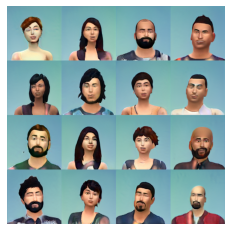

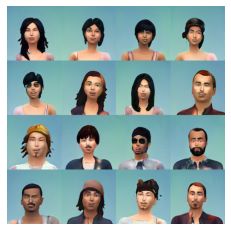

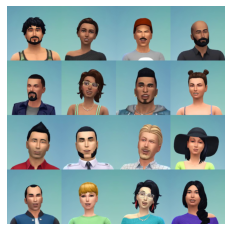

Step 14400. G loss: 1.54377. 	 D loss: 0.90750.


 23%|██▎       | 114/495 [12:11<40:42,  6.41s/it]

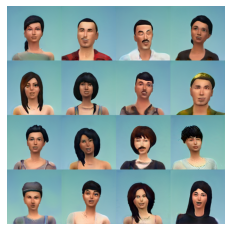

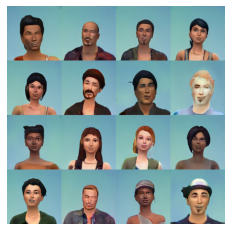

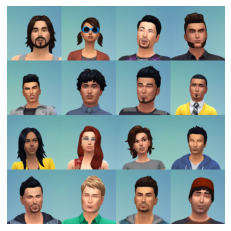

Step 15200. G loss: 1.54090. 	 D loss: 0.90191.


 91%|█████████ | 450/495 [48:09<04:47,  6.39s/it]

In [ ]:
code_dim = 512
n_classes = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
checkpoints_dir

# checkpoint = torch.load("/content/drive/MyDrive/data/gan/checkpoints/stylegan-256px.pt")
checkpoint = torch.load("/content/drive/MyDrive/data/gan/checkpoints/sims/pickles/stylegan_finetune_sims-step=13600.pt")

# pickle and image files names
save_name = "stylegan_finetune_sims"

# step to continue from if loading checkpoint
# cur_step = 0
cur_step = 12000

gen = StyledGenerator(code_dim=code_dim).to(device)
gen.load_state_dict(checkpoint['generator'])
gen_ema = StyledGenerator(code_dim=code_dim).to(device)
init_ema(gen_ema)
gen_ema.load_state_dict(checkpoint['g_running'])

dis = Discriminator(from_rgb_activate=True).to(device)
dis.load_state_dict(checkpoint['discriminator'])

gen_optim = torch.optim.Adam([
        {
            'params': gen.generator.parameters(),
            'sched': 1.0,
        },
        {
            'params': gen.style.parameters(),
            'sched': 0.01,
        },
    ], betas=betas)
dis_optim = torch.optim.Adam(
    [p for p in dis.parameters() if p.requires_grad],
    lr=lr, betas=betas,
)
gen_optim.load_state_dict(checkpoint['g_optim'])
dis_optim.load_state_dict(checkpoint['d_optim'])
cur_step = checkpoint['step']

# dataloader = torch.utils.data.DataLoader(
#     Dataset('data/animeface-character-dataset/thumb', n_classes=n_classes),
#     batch_size=16, pin_memory=True, shuffle=True, drop_last=True,
# )

dataloader = torch.utils.data.DataLoader(
    Dataset('/content/drive/MyDrive/data/gan/images/sims_imgz/', n_classes=1, resolution=128),
    batch_size=16, pin_memory=True, shuffle=True, drop_last=True,
)

finetune(
    [gen_ema, gen],
    dis,
    dataloader,
    code_dim,
    device,
    cur_step
)

### Inference

After you're happy with the quality of your FreezeD'd StyleGAN, you can run inference. Simply load the checkpoint from training and feed it some random noise to generate some cool anime faces!

In [ ]:
# Define some helper functions for inference
@torch.no_grad
def mean_style(generator, code_dim, device, batch=1024, batches=10):
    '''
    Function that computes the mean style vector.
    '''
    mean_style = []
    for i in range(batches):
        z = torch.randn(batch, code_dim).to(device)
        style = generator.mean_style(z)
        mean_style += [style]

    mean_style = torch.stack(mean_style, dim=0).mean(0)
    return mean_style

@torch.no_grad
def synthesize(generator, n_samples, code_dim, device):
    '''
    Function that samples random noise and generates a fake image.
    '''
    generator.eval()
    z = torch.randn(n_samples, code_dim, device=device)
    mean_style = mean_style(generator, code_dim, device)
    x = generator(z, step=step, alpha=1, mean_style=mean_style, style_weight=0.7)
    return x

n_samples = 16

# Load checkpoint
checkpoint = torch.load('stylegan-step=50000.pt')
generator = StyledGenerator(code_dim=code_dim).to(device)
generator.load_state_dict(checkpoint['generator'])

# Run inference
x = synthesize(generator, n_samples, code_dim, device)
show_tensor_images(x)

In [ ]:
pass 

In [ ]:
pass

In [ ]:
pass

In [ ]:
pass